# CerealTimeKillersNet: Deep neural network for emotional states predictions from EEG data.

## Setup

In [1]:
# Packages & self-implemented functions
from CTKNetFunctions import *


## Model settings - Change models here!

In [15]:
class CTK_RNN_Net(nn.Module):
    def __init__(self, input_shape, out_size):

        super(CTK_RNN_Net, self).__init__()
        
        # Model hyperparametres (layer by layer)
        conv_channel = [5, 5]
        conv_kernel = [(3, 3), (3, 3)]
        pool_kernel = [(1, 1), (1, 1)]
        rnn_layer = [1]
        rnn_unit = [64]
        rnn_drop = [0]
        fc_unit = []
        drop_out = []
        
        self.rnn_layer = rnn_layer
        self.rnn_unit = rnn_unit
        
        # Hidden layers
        img_size = np.array(input_shape[2:])
        
        fc_input_size = np.int(np.prod(img_size) * input_shape[1])
        
        self.rnn1 = nn.LSTM(input_size = fc_input_size, hidden_size = rnn_unit[0], num_layers = rnn_layer[0], dropout = rnn_drop[0], batch_first = True)
        
        self.fc1 = nn.Linear(in_features = rnn_unit[0] * rnn_layer[0], out_features = out_size[0])
        

    def forward(self, x):
        
        shape = x.shape
        x = x.view(shape[0] * shape[1], shape[2], shape[3], shape[4])
        
        hidden = (torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0]), 
                  torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0]))   # for LSTM
        # hidden = torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0])   # for simple RNN and GRU
        
        x = torch.flatten(x, 1)        
        x = x.view(shape[0], shape[1], -1)
        _, x = self.rnn1(x, hidden) # use final hidden state for non-series label prediction!
        x = x[0].permute(1, 0, 2) # for LSTM
        # x = x.permute(1, 0, 2) # for simple RNN and GRU
        x = F.relu(x)
        x = x.contiguous().view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = F.sigmoid(x)
        
        return x
    

In [17]:
# Model selection function
def CerealTimeKillersModelGenerator(args, size):
    
    model = CTK_RNN_Net(input_shape = size[0], out_size = size[1])
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum = args['momentum'])
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion


In [14]:
# Main function of model simulation
def CerealTimeKillersModelSimulator(args, label,
                                    TrainDataLoader, ValDataLoader, TestDataLoader, DataSize,
                                    is_2D = False,
                                    K_fold_train = False, k_folds = 1):
    
    N_FOLD = k_folds if K_fold_train else 1
    loss, acc, param, models = [], [], [], []
    
    for fold in range(N_FOLD):
        print('\n%d/%d Fold' % (fold + 1, N_FOLD))
        print('----------------------------')
    
        model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
        loss_list, acc_list, param_norm_list, trained_model, epoch = simulation(args, label, model,
                                                                                TrainDataLoader[fold],
                                                                                ValDataLoader[fold],
                                                                                TestDataLoader,
                                                                                is_2D = is_2D,
                                                                                optimizer = optimizer,
                                                                                criterion = criterion)
    
        loss_list, acc_list = np.array(loss_list), np.array(acc_list)
        loss.append([loss_list[0, epoch], loss_list[1, epoch], loss_list[2, epoch]])
        acc.append([acc_list[0, epoch], acc_list[1, epoch], acc_list[2, epoch]])
        param.append(param_norm_list[epoch])
        models.append(trained_model)
        
        print('Train/Val/Test Final MSE:', list(loss[-1]))
        print('Train/Val/Test Maximum Accuracy:', list(acc[-1]))
    
    return loss, acc, param, models



## Input settings - Change hypermatres here!

In [18]:
class CerealTimeKillersLabels:
    """
    Select labels for model prediction
    Labels used for prediction: info + electrode --> prediction
    CHANGE these with necessity before loading data
    """
    
    # ['subject', 'game', 'gender', 'age', 'disturbance', 'experience', 'memory']
    info = []
        
    # ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
    electrode = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
        
    # ['satisfied', 'boring', 'horrible', 'calm', 'funny', 'valence', 'arousal']
    prediction = ['boring', 'horrible', 'calm', 'funny']
    # prediction = ['valence', 'arousal']
    
    # Quadrant emotions (applied after predicting valence/arousal)
    quadrant = ['boring', 'horrible', 'calm', 'funny']
    
    # Fixed variables
    fixed = info + prediction
    
    # Summarise labels for model
    label = info + electrode + prediction


In [19]:
# General settings
workspace_dir = '' # Workspace directionary
LabelRange = [1, 9] # The [min, max] of emotional states for transformation

# Whether to allow between-window dataset mixture
# SET TO FALSE FOR 4-DIMENSIONAL INPUT WHEN USING RNN
Is_between_subject = False # Default is True for 3-dimensional input

# Whether to transform 2D emotion  (valence/arousal) to 4 quardrant emotions ()
Is_2D_to_quardrant_emotion = True # Default is False

# Which to be based for allocating testing dataset (only when Is_between_subject = True)
Allocation_test = None # [None, 'subject', 'game'] # Default is None
test_ratio = 0.2 # Proportion of data used for testing when Allocation_test == None
Target_test = [25, 26, 27] # Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None

# Model structural settings
N_inputtime = 1 # Time window for input sampling (Default is None for the whole timepoints)
N_stridetime = 1 # Temporal leap for input sampling when N_inputtime != None
N_perseg = 256 # N per seg of spectrogram
N_framerate = 128 # Framerate of spectrogram

# Model training settings
batch_size_train = 16 # Number of examples per minibatch during training
batch_size_test = 1 # Number of examples per minibatch during validation/testing
k_folds = 5 # Number for K-folds for training vs validation (validation is 1/k_folds of the train/val set)
K_fold_train = True # Whether enable the full K-fold cross-validation for training (if False, validate only once)

# Model hypermparametres
args = {
    'epochs': 300,
    'lr': 3e-3,
    'momentum': 0.99,
    'l1': 1e-3,
    'l2': 1e-3,
    'patience': 50,
    'device': set_device(),
}
print('Current device:', args['device'])

# Set random seed for reproducibility
SEED = 2021
set_seed(seed = SEED)
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Torch-based data transformation
data_transform = None


Current device: cpu
Random seed 2021 has been set.


## MAIN CODE

In [20]:
# Implement Dataloader
FullDataset, DataSize, ExpIndex = CerealTimeKillersDataLoader(dir_base = workspace_dir,
                                                              label_class = CerealTimeKillersLabels,
                                                              label_range = LabelRange,
                                                              dataset_mix = Is_between_subject,
                                                              winlen = N_inputtime,
                                                              stride = N_stridetime,
                                                              nperseg = N_perseg,
                                                              fs = N_framerate,
                                                              transform = data_transform)

# Implement DataSplitter
SplittedDataset, SplittedDataLength = CerealTimeKillersDataSplitter(FullDataset, 
                                                                    exp_index = ExpIndex, 
                                                                    allocation_test = Allocation_test,
                                                                    test_ratio = test_ratio,
                                                                    target_test = Target_test,
                                                                    k_folds = k_folds,
                                                                    batch_size_train = batch_size_train,
                                                                    batch_size_test = batch_size_test,
                                                                    seed = SEED,
                                                                    generator = g_seed)

# Load Splited data
(TrainDataLoader, ValDataLoader, TestDataLoader) = (SplittedDataset['train'],
                                                    SplittedDataset['val'],
                                                    SplittedDataset['test'])

# Show data size
print('Dataset length:', SplittedDataLength)
print('Input shape: [channel, frequency, time]')
print('Single input data size:', DataSize[0])
print('Single output data size:', DataSize[1])


Dataset length: {'train': 70, 'val': 17, 'test': 21}
Input shape: [channel, frequency, time]
Single input data size: (169, 14, 129, 1)
Single output data size: (4,)


In [21]:
# Model selection
model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
print(model)
# summary(model, DataSize[0])


CTK_RNN_Net(
  (rnn1): LSTM(1806, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=4, bias=True)
)



1/5 Fold
----------------------------


/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.13557057082653046 0.1254283253931337 0.13826986145050751
Train/Val/TEST Accuracy: 53.6231884057971 61.111111111111114 28.571428571428573
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.12056991159915924 0.11091776606109408 0.13268066472595647
Train/Val/TEST Accuracy: 53.6231884057971 66.66666666666667 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.1079930916428566 0.10606504128211075 0.13220348896547443
Train/Val/TEST Accuracy: 53.6231884057971 66.66666666666667 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.10416644811630249 0.10468004436956511 0.12770129922067835
Train/Val/TEST Accuracy: 53.6231884057971 66.66666666666667 28.571428571428573
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.09378557354211807 0.10199494432244036 0.12383328639857825
Train/Val/TEST Accuracy: 53.6231884057971 66.66666666666667 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.07889483720064164 0.1010686531662941 0.11596707556219328
T

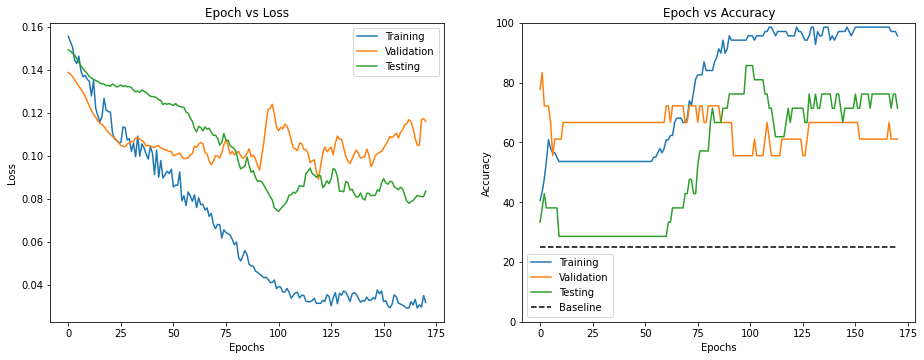

Train/Val/Test Final MSE: [0.03154579438269138, 0.08913841760820812, 0.09095315692857617]
Train/Val/Test Maximum Accuracy: [95.65217391304348, 61.111111111111114, 66.66666666666667]

2/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.14134574830532073 0.1297808529602157 0.14768288213582265
Train/Val/TEST Accuracy: 60.869565217391305 44.44444444444444 28.571428571428573
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.1146416112780571 0.11287636992832024 0.14122140842179456
Train/Val/TEST Accuracy: 57.971014492753625 50.0 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.11386011093854904 0.11395989627473885 0.14047695891488166
Train/Val/TEST Accuracy: 57.971014492753625 50.0 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.09281829595565796 0.11337431033866273 0.13373081029082337
Train/Val/TEST Accuracy: 57.971014492753625 50.0 28.571428571428573
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.08465647920966149 0.10862845968868998 0.13020469787131464
Train/Val/TEST Accuracy: 57.971014492753625 50.0 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.0834048792719841 0.10664205791221724 0.12049194425344467
Train/Val/TEST Accuracy: 57.971014492753625 

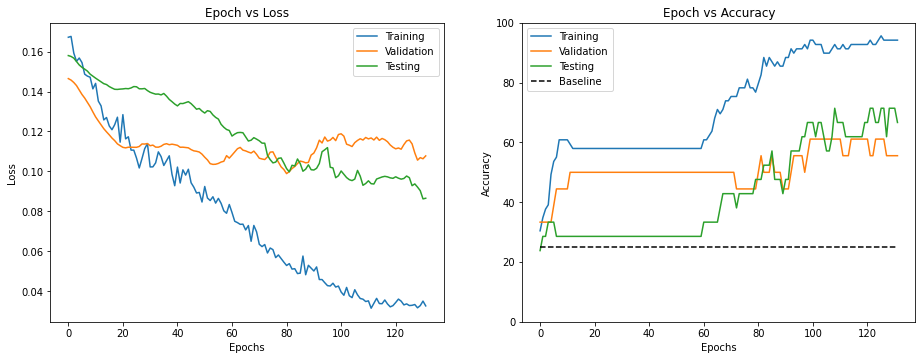

Train/Val/Test Final MSE: [0.052856375277042386, 0.09888351320599516, 0.10139844619802066]
Train/Val/Test Maximum Accuracy: [79.71014492753623, 50.0, 47.61904761904762]

3/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.1337728127837181 0.15528498107896133 0.14390200341031664
Train/Val/TEST Accuracy: 58.57142857142857 58.8235294117647 33.333333333333336
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.10900538563728332 0.1384848691523075 0.13795433264403117
Train/Val/TEST Accuracy: 55.714285714285715 58.8235294117647 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.09759456664323807 0.13591039290322976 0.14200502341347082
Train/Val/TEST Accuracy: 55.714285714285715 58.8235294117647 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08948790431022643 0.13401533707099803 0.14387683685691582
Train/Val/TEST Accuracy: 55.714285714285715 58.8235294117647 28.571428571428573
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.08324683755636215 0.13491558174000068 0.1386715051318918
Train/Val/TEST Accuracy: 55.714285714285715 58.8235294117647 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.07138474136590958 0.1252010266351349 0.1312956977635622


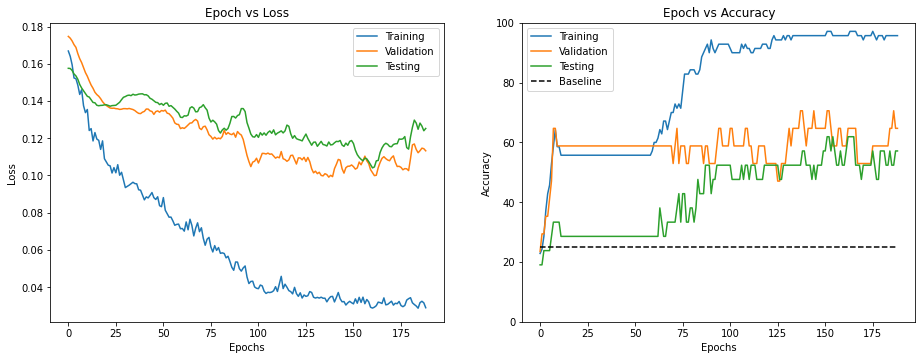

Train/Val/Test Final MSE: [0.03378555215895176, 0.09911951170686413, 0.11800216085144452]
Train/Val/Test Maximum Accuracy: [95.71428571428571, 70.58823529411765, 52.38095238095238]

4/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.13324007391929626 0.14620290170697606 0.1427724308201245
Train/Val/TEST Accuracy: 58.57142857142857 52.94117647058823 33.333333333333336
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.10629700869321823 0.1301345820812618 0.14053481781766528
Train/Val/TEST Accuracy: 57.142857142857146 52.94117647058823 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.0987837553024292 0.12952430108014276 0.14269422606698104
Train/Val/TEST Accuracy: 57.142857142857146 52.94117647058823 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.10466041415929794 0.13199889714665272 0.1453494837596303
Train/Val/TEST Accuracy: 57.142857142857146 52.94117647058823 28.571428571428573
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.08526175916194915 0.13116527556934776 0.1423684721369119
Train/Val/TEST Accuracy: 57.142857142857146 52.94117647058823 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.0753159761428833 0.13121718540787697 0.13433369892161

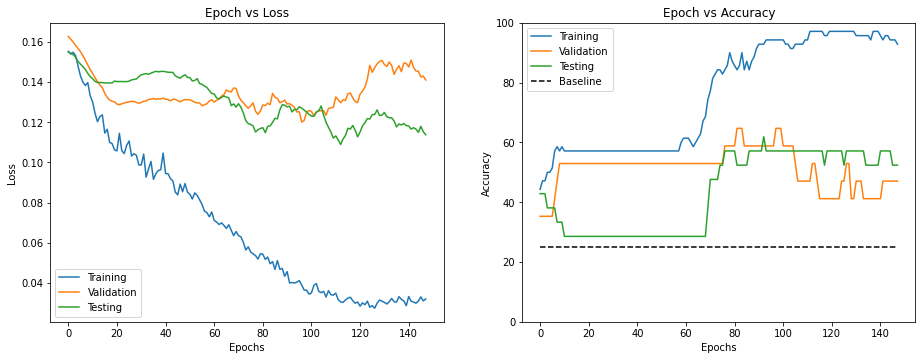

Train/Val/Test Final MSE: [0.03892190083861351, 0.12009215327527593, 0.12704674021473952]
Train/Val/Test Maximum Accuracy: [94.28571428571429, 58.8235294117647, 57.142857142857146]

5/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.12677700817584991 0.16540810465812683 0.13881683997100308
Train/Val/TEST Accuracy: 57.142857142857146 47.05882352941177 23.80952380952381
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.10705040842294693 0.1409718039281228 0.13425137528351375
Train/Val/TEST Accuracy: 57.142857142857146 52.94117647058823 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.10328082889318466 0.13485586292603435 0.1336792473282133
Train/Val/TEST Accuracy: 57.142857142857146 52.94117647058823 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.0891247570514679 0.1335248213042231 0.13375864834302947
Train/Val/TEST Accuracy: 57.142857142857146 52.94117647058823 28.571428571428573
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.0807232141494751 0.13582301074091127 0.12367730645374173
Train/Val/TEST Accuracy: 58.57142857142857 52.94117647058823 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.0669280543923378 0.13675769155516343 0.123355575260661

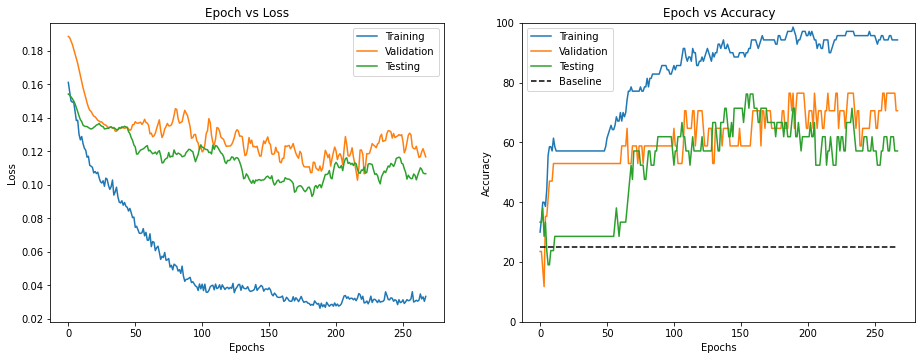

Train/Val/Test Final MSE: [0.03236714377999306, 0.10271838723736651, 0.10923056770116091]
Train/Val/Test Maximum Accuracy: [90.0, 70.58823529411765, 57.142857142857146]


In [22]:
# Model simulation
loss_K, acc_K, param_K, models_K = CerealTimeKillersModelSimulator(args, CerealTimeKillersLabels, 
                                                                   TrainDataLoader,
                                                                   ValDataLoader,
                                                                   TestDataLoader,
                                                                   DataSize,
                                                                   K_fold_train = K_fold_train,
                                                                   k_folds = k_folds)


In [23]:
# Average results from K-folds
print('Train/Val/Test Average MSE:', list(np.mean(np.array(loss_K), axis = 0)))
print('Train/Val/Test Average Accuracy:', list(np.mean(np.array(acc_K), axis = 0)))


Train/Val/Test Average MSE: [0.037895353287458425, 0.10199039660674196, 0.10932621437878835]
Train/Val/Test Average Accuracy: [91.07246376811594, 62.222222222222214, 56.19047619047619]


## Single prediction results

In [24]:
# Print single prediction results from data loader
fold = 0
ShowDataset = TestDataLoader
ShowModel = models_K[fold]
BATCH_SHOW = 20

ShowModel.eval()

with torch.no_grad():
    for idx, (data, target, quadrant) in enumerate(ShowDataset):
        data = data.type(torch.float).to(args['device'])
        target = target.type(torch.float).to(args['device'])
        quadrant = quadrant.type(torch.float).to(args['device'])
        output = ShowModel(data)
            
        eval_loss = criterion(output, target).item()
        
        if not Is_2D_to_quardrant_emotion:
            predicted = maximum_extraction(output)
            labels = maximum_extraction(target)
        else:
            predicted = emotion_transformation(output, CerealTimeKillersLabels)
            flabels = maximum_extraction(quadrant)
            labels = emotion_transformation(target, CerealTimeKillersLabels)
        
        eval_acc = maximum_comparison(predicted, labels) * 100.0 / target.size(0)
        
        if idx < BATCH_SHOW:
            print('Batch', idx + 1, ' ( Size', target.size(0), '):')
            print('Output Example:', output[0].detach().numpy(), 'with label ', predicted[0])
            if not Is_2D_to_quardrant_emotion:
                print('Target Example:', target[0].detach().numpy(), 'with label ', labels[0])
            else:
                print('Target Example:', target[0].detach().numpy(), 'with label ', flabels[0])
                print('Real Label Example:', quadrant[0].detach().numpy(), 'with label ', labels[0])
            print('------- MSE:', eval_loss, ' Accuracy:', eval_acc, '%-------\n')
        else:
            print('Etc. for totally ', len(ShowDataset), 'batches.')
            break
 

Batch 1  ( Size 1 ):
Output Example: [0.12939595 0.5583356  0.28458208 0.2801738 ] with label  [1]
Target Example: [0.    1.125 0.125 0.   ] with label  [1]
Real Label Example: [ 1. 10.  2.  1.] with label  [1]
------- MSE: 0.11045391857624054  Accuracy: 100.0 %-------

Batch 2  ( Size 1 ):
Output Example: [0.6080416  0.12115587 0.36050996 0.3959233 ] with label  [2]
Target Example: [1.125 0.    1.125 0.   ] with label  [0, 2]
Real Label Example: [10.  1. 10.  1.] with label  [2]
------- MSE: 0.25578123331069946  Accuracy: 100.0 %-------

Batch 3  ( Size 1 ):
Output Example: [0.19531624 0.4836512  0.3790247  0.36588874] with label  [0]
Target Example: [0.875 0.    0.25  0.   ] with label  [0]
Real Label Example: [8. 1. 3. 1.] with label  [2]
------- MSE: 0.2116026133298874  Accuracy: 0.0 %-------

Batch 4  ( Size 1 ):
Output Example: [0.23490618 0.18189354 0.55222297 0.4046966 ] with label  [0]
Target Example: [0.    0.    0.5   0.875] with label  [3]
Real Label Example: [1. 1. 5. 8.] 